# Implementing LSM

In [1]:
import numpy as np
#import math
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

In [201]:
class MonteCarloOptionPricing:
    def __init__(self, r, S0: float, K: float, T: float, σ: float,
                 dim: int, n: int, seed: int):
        """ WRITE TEXT EXPLAINING CLASS...
        
        Parameters: 
        S0 (float): Initial asset value
        K (float): strike price
        T (float): time to maturity, in years, a float number
        r (float): risk-free interest rate
        σ (float): volatility coefficient for diffusion
        dim (int): number of paths to simulate
        n (int): between time 0 and time T, the number of time steps 
        """
        
        assert σ >= 0, 'volatility cannot be less than zero'
        assert S0 >= 0, 'initial stock price cannot be less than zero'
        assert T >= 0, 'time to maturity cannot be less than zero'
        assert n >= 0, 'no. of slices per year cannot be less than zero'
        assert dim >= 0, 'no. of simulation paths cannot be less than zero'
        
        # Set the random seed for reproducibility
        np.random.seed(seed)

        self.r = float(r)
        self.S0 = float(S0)
        self.K = float(K)
        self.T = float(T)
        self.σ = float(σ)
        self.n = int(n)
        self.dim = int(dim)
        self.Δ = self.T / self.n
        self.df = np.exp(-self.r*self.Δ)
        self.Z = np.random.normal(0, 1, (self.n, self.dim)) # white noise (drawn all at once)
        self.S = np.full((self.n, self.dim), np.nan)  # Allocate space for stock price process, with an extra step for initial value

    def GeometricBrownianMotion(self):
        """ Generate GBM paths according to Algorithm 3.
        
        Returns:
        np.ndarray: Simulated paths of the asset price.
        """
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        
        S[0,:] = np.log(S0)  # Set initial values
        for i in range(n-1):
            S[i+1,:] = S[i,:] + (r-0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z[i,:]
            
        self.S = np.exp(S)  # Exponentiate to get the GBM paths
        return self.S
    
    def MertonJumpDiffusion(self,α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = float(α)
        self.β = float(β)
        self.λ = float(λ)
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim

        S[0,:] = np.log(S0) 
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)
        for i in range(n-1):
            N = np.random.poisson(λ*Δ, dim)  # Poisson process for the number of jumps
            # Jump sizes for each path
            M = np.zeros(dim)
            for j in range(dim):
                if N[j] > 0: # if jump
                    M[j] = α*N[j] + β*np.sqrt(N[j])*np.random.normal()
            # Calculate the combined diffusion and jump process
            S[i+1,:] = S[i,:] + c*Δ + σ*np.sqrt(Δ)*Z[i,:] + M
            
        self.S = np.exp(S) 
    
        return self.S
    
    def CEV(self,γ: float):
        """
        Generate CEV paths according to Algorithm 5. 
        
        Parameters:
        γ (float): parameter governing elasticity with respect to price
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """ 
        assert γ>= 0, 'cant let elasticity be negative due to leverage effect'
        self.γ = float(γ)

        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        γ = self.γ
        σ = self.σ
        n = self.n

        S[0,:] = S0  # Set initial values
        # Simulation using the Euler-Maruyama method for the CEV model
        for i in range(n-1):
            S[i+1,:] = S[i,:] + r*S[i,:]*Δ + σ*S[i,:]**(γ/2)*np.sqrt(Δ)*Z[i,:]
        self.S = S

        return self.S
    
    def american_option_LSM(self, poly_degree: int, option_type: str = 'put'):
        """
        American option pricing using LSM method as outlined in Algorithm 1.
        
        Parameters:
        poly_degree (int): degree of polynomials 
        option_type (str): call or put (default)
        
        Return: 
        float: V0, expected call/put option valuation
        """
        assert option_type == 'call' or option_type == 'put', 'Invalid option type'
        assert len(self.S) != 0, 'Please simulate the stock price first'
        
        # unpack parameters
        K = self.K
        S = self.S
        S0 = self.S0
        r = self.r
        dim = self.dim
        Δ = self.Δ
        n = self.n

        if option_type == 'put':
            self.intrinsic_val = np.maximum(K - S, 0.)
            print(self.intrinsic_val.size)
        elif option_type == 'call':
            self.intrinsic_val = np.maximum(S - K, 0.)

        # terminal == last day intrinsic value (trivial case)
        V = self.intrinsic_val[-1]
        
        # initialize stopping rule
        stopping_rule = np.zeros_like(S)
        stopping_rule[:,-1] = np.where(self.intrinsic_val[:,-1] > 0, 1, 0)

        # American Option Valuation by Backward Induction
        for t in range(n - 2, 1, -1): # exclude period 0 as done in Glasserman
            # find out in-the-money path to better estimate the conditional expectation function
            # where exercise is relevant and significantly improves the efficiency of the algorithm
            itm_path = np.where(self.intrinsic_val[t,:] > 0)
            print(self.intrinsic_val[t,:].size)

            V = V*np.exp(-r*Δ)
            print(V.size)
            Y = V[itm_path]
            print(V[itm_path].size)
            X = S[t,itm_path]
            print(X.size)

            # initialize continuation value
            C = np.zeros(shape=dim)
            
            # if only 5 in-the-money paths (most likely appear in out-of-the-money options)
            # assume C = 0. Otherwise, run regression and compute conditional expectation.
            if len(itm_path) > 5:
                rg = np.polyfit(x=X, y=Y, deg=poly_degree)  # regression fitting with ITM
                C[itm_path] = np.polyval(p=rg, x=X)  # continuation value
            print(len(itm_path))

            # 1 <==> exercise, 0 <==> hold
            stopping_rule[:,t] = np.where(self.intrinsic_val[:,t]>C, 1, 0)
            # if exercise at t, all future stopping rules = 0 as the option contract is exercised.
            stopping_rule[np.where(self.intrinsic_val[:,t]>C), (t+1):] = 0

            # cashflow at t, if hold, V = 0, if exercise, V = intrinsic value at t.
            V = np.where(self.intrinsic_val[:,t] > 0, self.intrinsic_val[:,t], 0)

        simulation_vals = (self.intrinsic_val * stopping_rule).sum(axis=1)
        self.V0 = np.exp(-r*Δ)*np.average(simulation_vals)

        return self.V0
        
    def plot_paths(self):
        """
        Plot simulated GBM paths.
        """

        # Define time interval
        time = np.linspace(0, self.T, self.n)
        tt = np.broadcast_to(time[:, None], (self.n, self.dim))

        # Plot
        plt.plot(tt, self.S)
        plt.xlabel("Time, $t$")
        plt.ylabel("Stock Price, $S_t$")
        plt.title(f'{self.dim} Number of Stock Price Process Simulation Paths')
        plt.show()

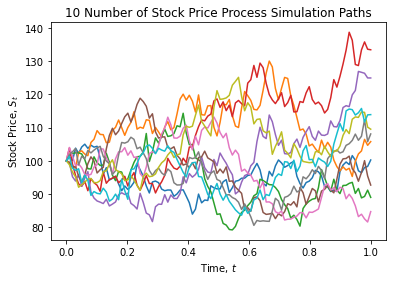

In [204]:
# Initialize the Monte Carlo option pricing with a specific seed
mc_option_pricing = MonteCarloOptionPricing(r=0.03, S0=100., K=100., T=1., σ=0.25, dim=10, n=100, seed=42)

# Generate 'dim' no. of stock price process paths
simulated_paths = mc_option_pricing.GeometricBrownianMotion()
#simulated_paths = mc_option_pricing.MertonJumpDiffusion(α=-0.5,β=0.4,λ=0.4)
#simulated_paths = mc_option_pricing.CEV(γ=1.5)
mc_option_pricing.plot_paths()  # This will generate and plot the GBM paths

In [205]:
mc_option_pricing.american_option_LSM(poly_degree = 3, option_type= 'put')

1000
10
10
4
4
1


IndexError: index 98 is out of bounds for axis 1 with size 10